# Import JSON Database containing 5SS mechanisms

In [1]:
import json
with open('database5SS.txt') as f:
    json_data = json.load(f)
#print(json.dumps(json_data, indent=4))

# Create numpy arrays for data

In [35]:
import numpy as np

MechList=[];
CplrPathList=[];
for d in json_data:
    MechList.append(np.asarray(d["Mech"]))
    CplrPathList.append(np.asarray(d["CplrPath"]))

# Plot sample Coupler curve data

In [43]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from IPython import display
from numpy import linalg as LA


def plotPath(Pts, ax, limit):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, 'gray')
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

<IPython.core.display.Javascript object>


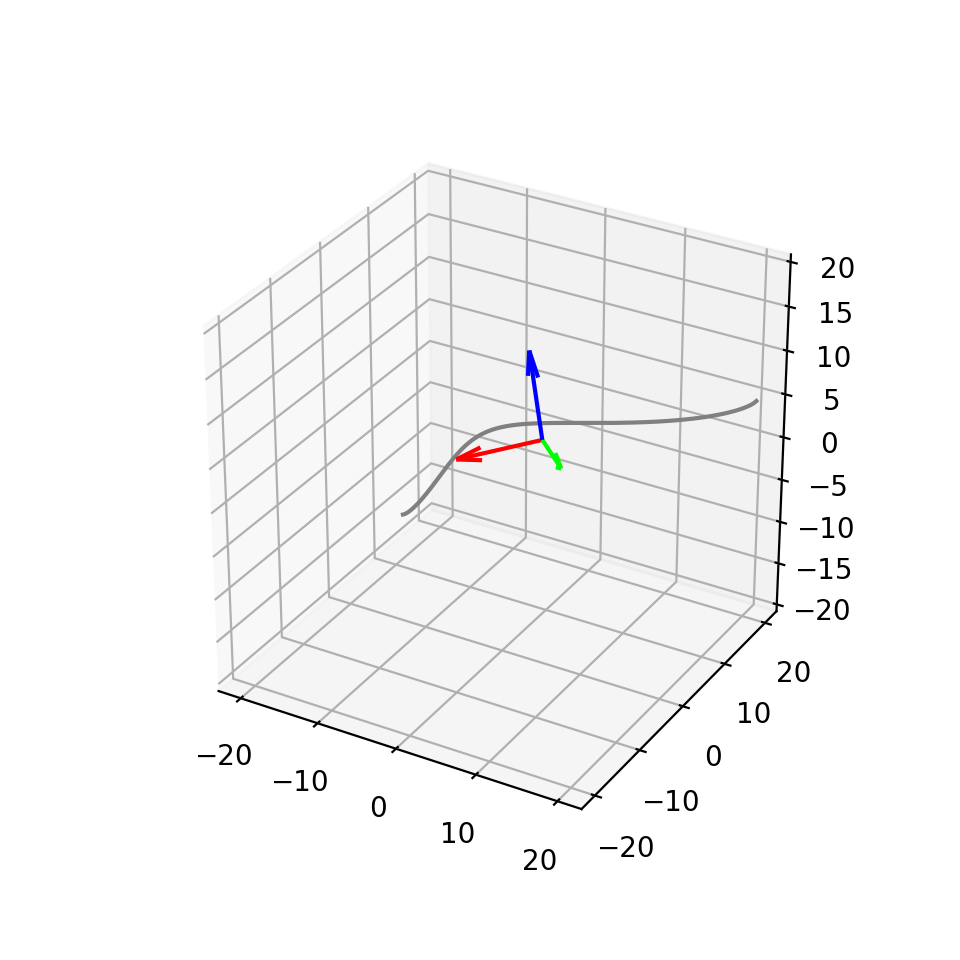

In [54]:
Pts=CplrPathList[6]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, 20)
        
C=np.mean(Path1,axis=0)
Covariance_Mat=np.cov(Pts,rowvar=0)
sing_vec=LA.svd(Covariance_Mat)[0]
R=sing_vec.T*10
plotXYZ(C, R, ax)

<IPython.core.display.Javascript object>


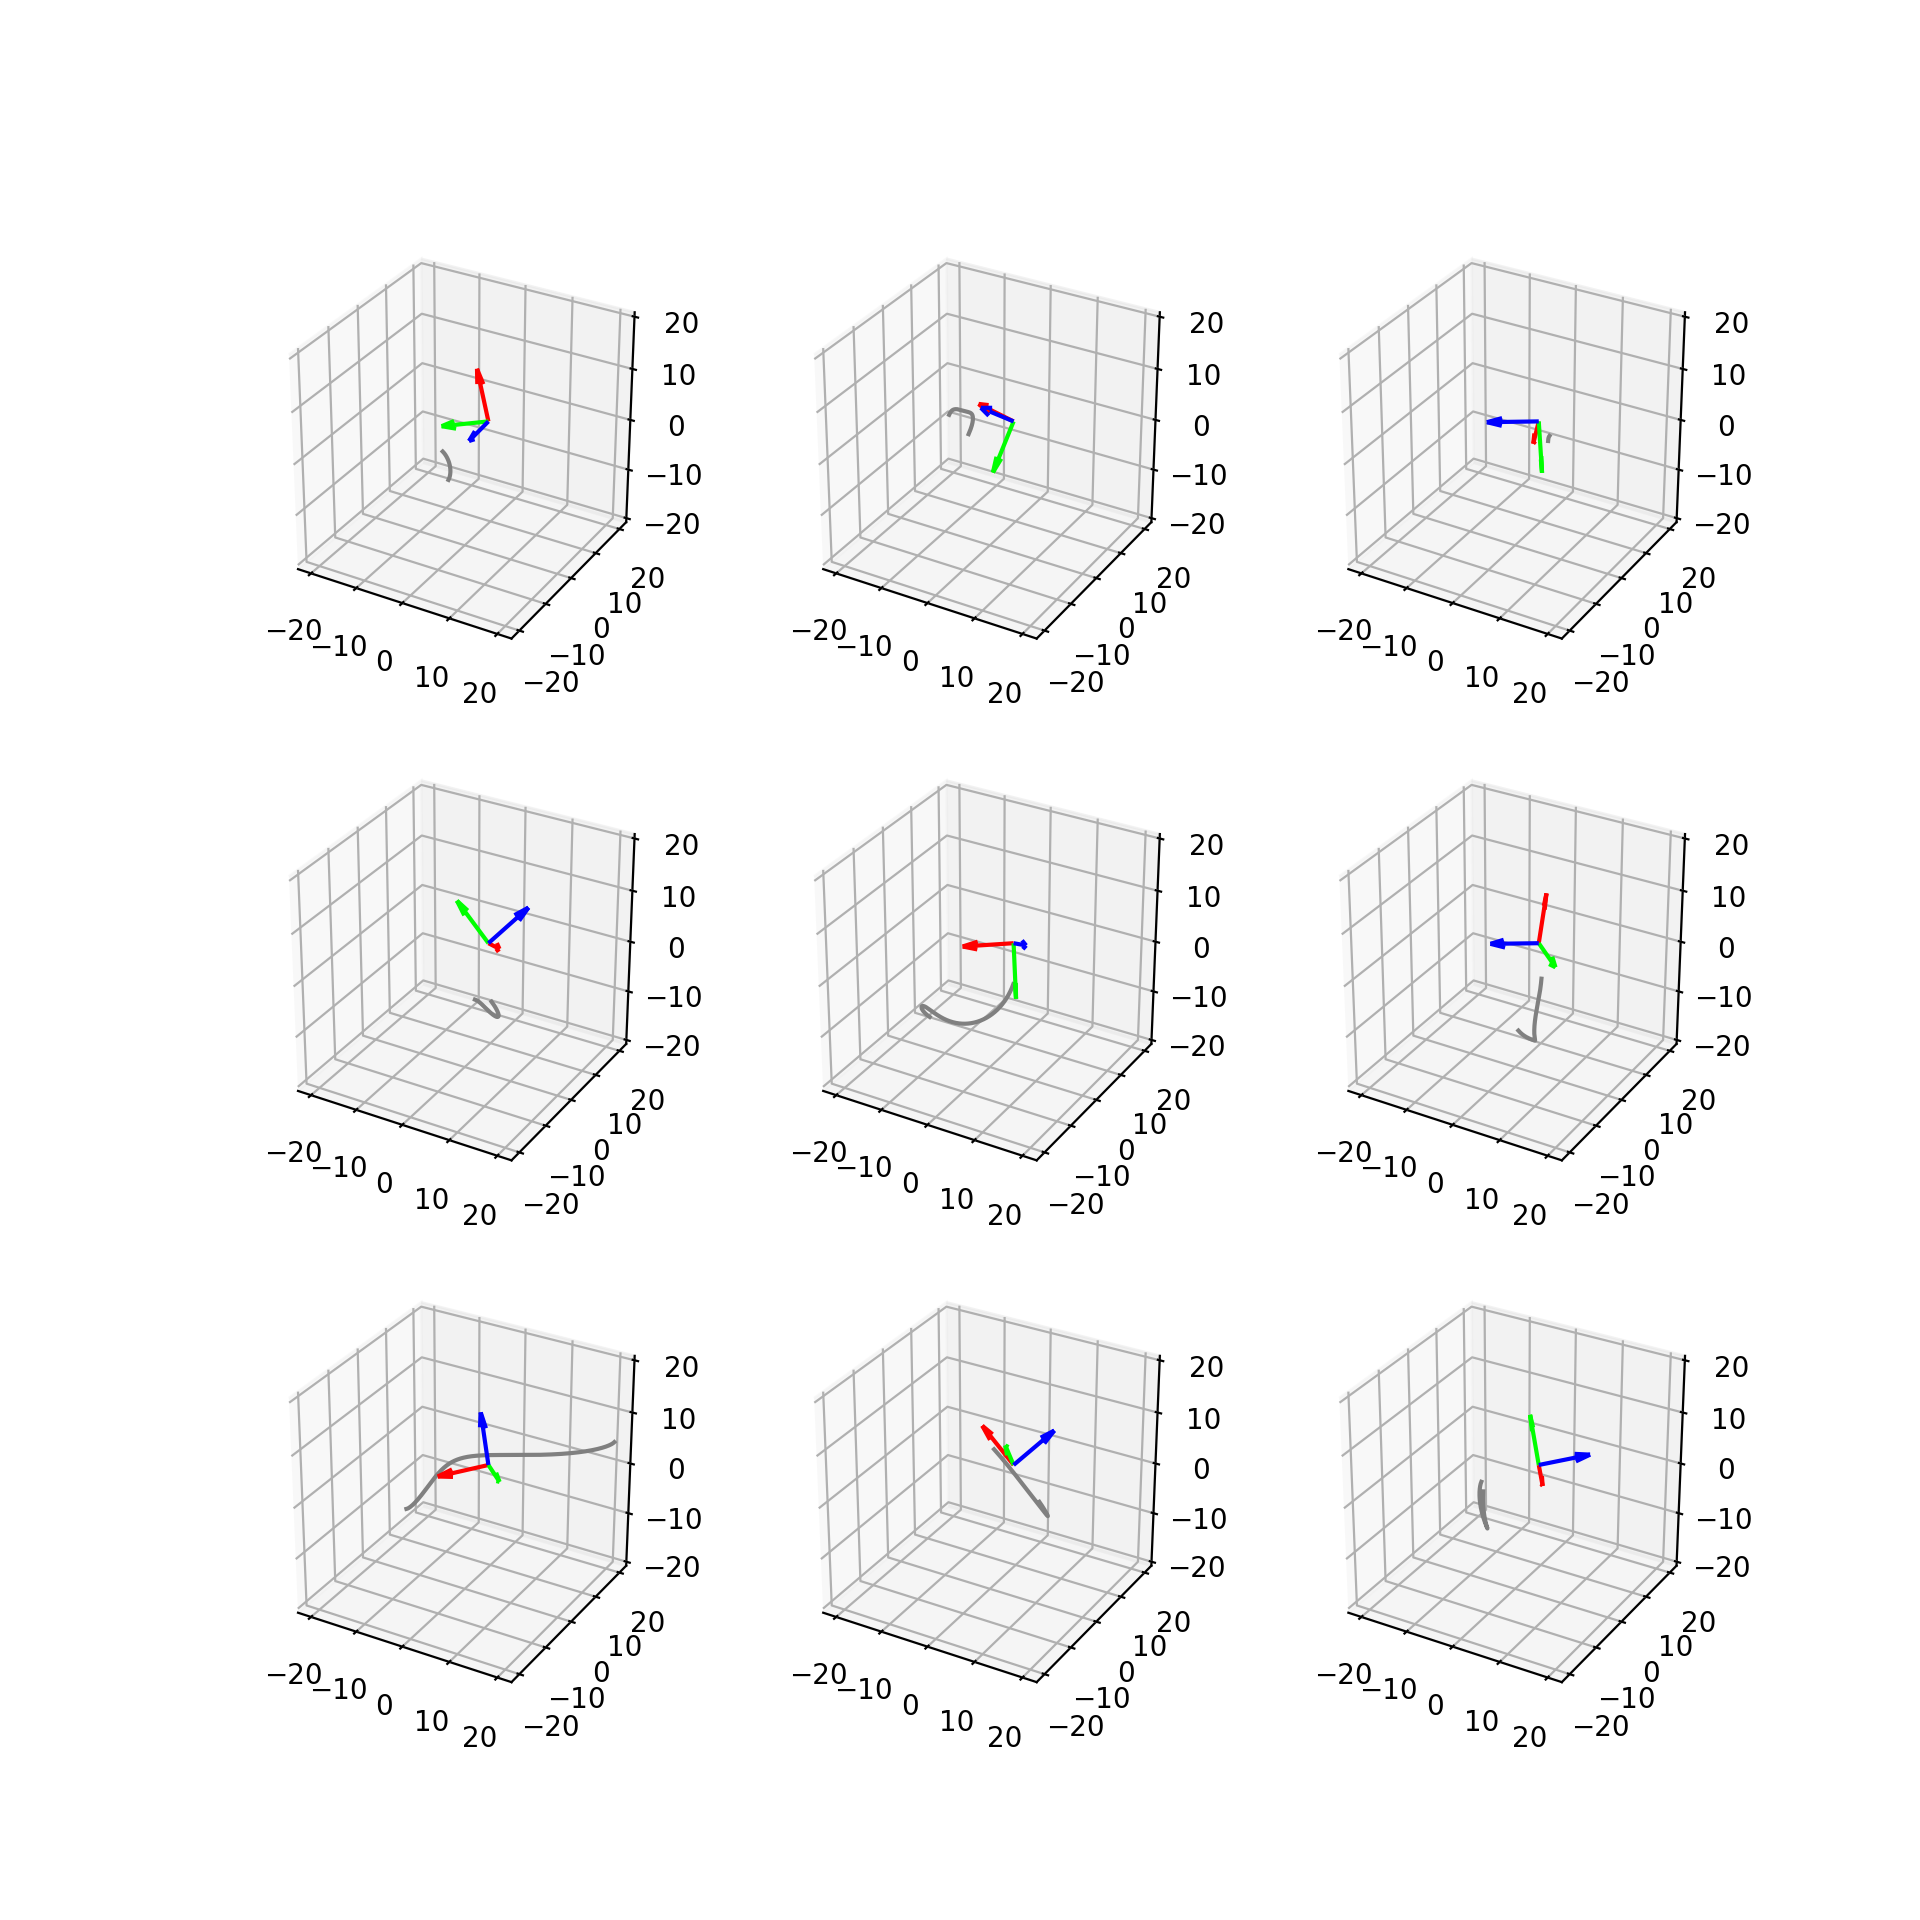

In [55]:
rows=3
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(cols/rows))
for i in range(rows):
    for j in range(cols):
        Pts=CplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(cols, rows, path_index, projection='3d')
        plotPath(Pts, ax, 20)
        
        C=np.mean(Path1,axis=0)
        Covariance_Mat=np.cov(Pts,rowvar=0)
        sing_vec=LA.svd(Covariance_Mat)[0]
        R=sing_vec.T*10
        plotXYZ(C, R, ax)

# Normalize Data (Translation,Rotation, Scaling)

- Translation: Average of all points moved to origin.
- Rotation: Principal axes rotated to align with x-axis
- Scaling: Divide points by maximum standard deviation

In [78]:
def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    S=np.max(np.std(Rot_Path,axis=0))
    Scale_Path=Rot_Path/S

    return Scale_Path, T, R, S

def normalizeMech(Mech, Translate, Rotate, Scale):
    Trans_Mech=Mech-Translation
    Rot_Mech=np.matmul(Rotate,Trans_Mech.T).T
    Scale_Mech=Rot_Mech/Scale
    return Scale_Mech

<IPython.core.display.Javascript object>


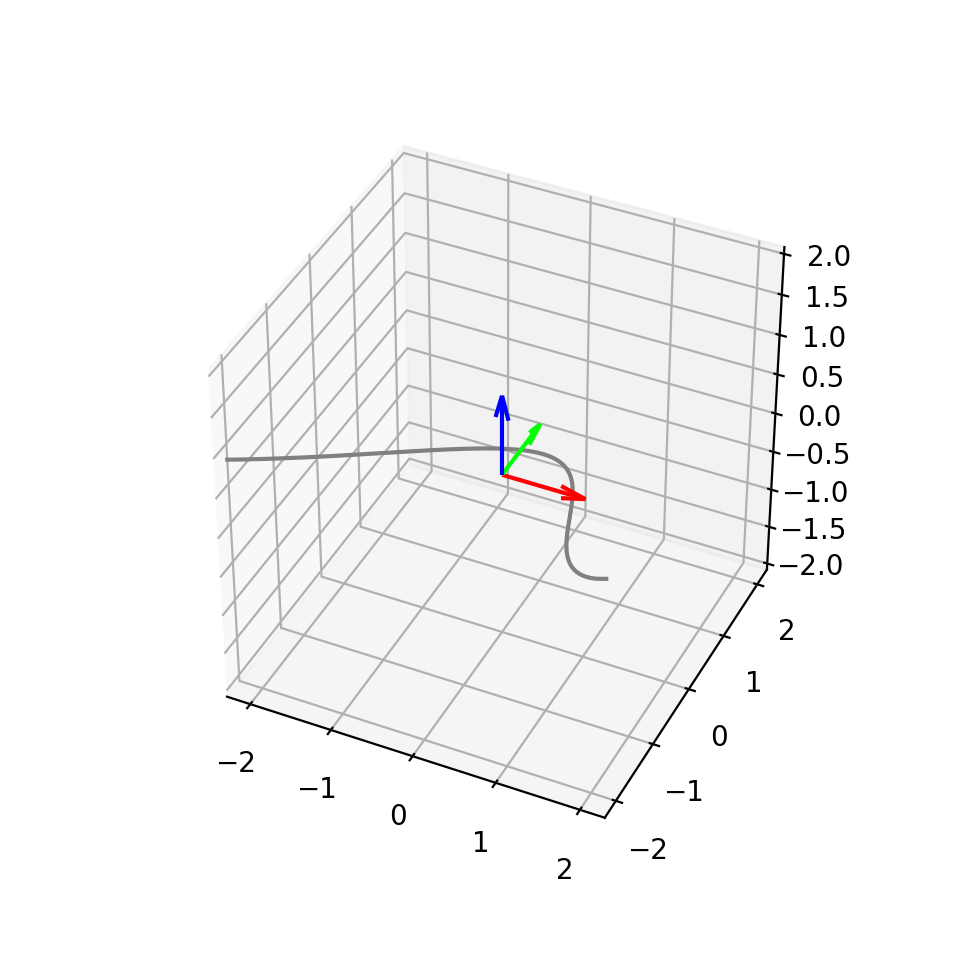

In [80]:
Path=CplrPathList[23]
nPath, T, R, S=normalizePath(Path)
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

In [82]:
NormMechList=[];
NormCplrPathList=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList[i]
    Mech=MechList[i]
    
    nPath, T, R, S=normalizePath(Path)
    nMech=normalizeMech(Mech, T, R, S)
    
    NormMechList.append(nMech)
    NormCplrPathList.append(nPath)

# Find Path Descriptors

# Perform Hierarchical Clustering